In [1]:
from pyspark.sql import functions as sparkf

In [2]:
import time as t
start_time = t.time()

### 1. Business Understanding

Problem Statement:  Prediction of Arrival Delay

Project Objective: (1) Regression Model (2) Model Deployment

### 2. Data Understanding

#### Data collection - ดึงไฟล์ 2008.csv จาก s3.amazonaws.com มาไว้ใน Linux File System

In [3]:
! wget https://s3.amazonaws.com/imcbucket/data/flights/2008.csv

--2022-10-04 16:17:24--  https://s3.amazonaws.com/imcbucket/data/flights/2008.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.69.206
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.69.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 689413344 (657M) [binary/octet-stream]
Saving to: ‘2008.csv.4’

2008.csv.4          100%[===================>] 657.48M  84.7MB/s    in 7.9s    

2022-10-04 16:17:32 (83.7 MB/s) - ‘2008.csv.4’ saved [689413344/689413344]



#### นับจำนวนบรรทัดในไฟล์ 2008.csv

In [4]:
! wc -l ./2008.csv

7009729 ./2008.csv


#### ดู Content ในไฟล์ 2008.csv

In [5]:
! head -3 2008.csv

Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
2008,1,3,4,2003,1955,2211,2225,WN,335,N712SW,128,150,116,-14,8,IAD,TPA,810,4,8,0,,0,NA,NA,NA,NA,NA
2008,1,3,4,754,735,1002,1000,WN,3231,N772SW,128,145,113,2,19,IAD,TPA,810,5,10,0,,0,NA,NA,NA,NA,NA


#### ลบ Directory และไฟล์ 2008.csv ที่มีอยู่เดิมใน HDFS

In [6]:
! hdfs dfs -rm -f /user/cloudera/input/2008.csv

Deleted /user/cloudera/input/2008.csv


#### สร้าง Directory "input" ใน HDFS

In [7]:
! hdfs dfs -mkdir -p /user/cloudera/input

#### Copy ไฟล์ 2008.csv จาก Linux File System ไปไว้ใน Directory "input" ของ HDFS

In [8]:
! hadoop fs -put 2008.csv /user/cloudera/input

#### แสดงและตรวจดูให้แน่ใจว่ามีไฟล์ 2008.csv อยู่ใน "input"

In [9]:
! hdfs dfs -ls /user/cloudera/input

Found 1 items
-rw-r--r--   2 root hadoop  689413344 2022-10-04 16:17 /user/cloudera/input/2008.csv


#### Spark อ่านไฟล์ 2008.csv จาก HDFS มาเป็น DataFrame

In [10]:
airline_df = spark.read.format('csv').\
option('header','true').option('mode','DROPMALFORMED')\
.option('inferSchema','true')\
.load('/user/cloudera/input/2008.csv')

#### Spark นับจำนวน tuple ใน DataFrame

In [11]:
airline_df.count()

7009728

#### Spark: Assign ค่าของตัวแปรเก่า ให้กับตัวแปรใหม่

In [12]:
airline_row_df = airline_df.filter(sparkf.col('Cancelled') != 1)

In [13]:
airline_row_df.count()

6872294

#### Spark แสดง Schema ของข้อมูลใน DataFrame

In [14]:
airline_row_df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- CRSElapsedTime: string (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)
 |-- Car

In [15]:
airline_row_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Year,6872294,2008.0,0.0,2008,2008
Month,6872294,6.388807871141718,3.399133826963632,1,12
DayofMonth,6872294,15.738505075597756,8.801003721431155,1,31
DayOfWeek,6872294,3.925949035358499,1.9885131747360885,1,7
DepTime,6872294,1333.8172957967165,478.0562519979256,1,959
CRSDepTime,6872294,1325.020889822234,464.28937283725134,0,2359
ArrTime,6872294,1481.258226684178,505.2251293380162,1,NA
CRSArrTime,6872294,1493.8976779805987,482.69853873327037,0,2400
UniqueCarrier,6872294,None,None,9E,YV


### 3. Data Preparation

#### Spark เรียกใช้ Data Types และ Functions ต่างๆ สำหรับจัดการข้อมูลใน DataFrame

In [16]:
from pyspark.sql.types import *
from pyspark.sql.functions import col, udf

In [17]:
crunched_df = airline_row_df.\
withColumn('DepTime',airline_row_df['DepTime'].\
           cast(DoubleType())).\
withColumn('TaxiOut',airline_row_df['TaxiOut'].\
           cast(DoubleType())).\
withColumn('TaxiIn',airline_row_df['TaxiIn'].\
           cast(DoubleType())).\
withColumn('DepDelay',airline_row_df['DepDelay'].\
           cast(DoubleType())).\
withColumn('DayOfWeek',airline_row_df['DayOfWeek'].\
           cast(DoubleType())).\
withColumn('Distance',airline_row_df['Distance'].\
           cast(DoubleType())).\
withColumn('ArrDelay',airline_row_df['ArrDelay'].\
           cast(DoubleType()))

#### Spark แสดง Schema ของข้อมูลใน DataFrame หลังจาก cast type แล้ว

In [18]:
crunched_df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: double (nullable = true)
 |-- DepTime: double (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- CRSElapsedTime: string (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: double (nullable = true)
 |-- TaxiIn: double (nullable = true)
 |-- TaxiOut: double (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)
 |-- Carri

#### Python ติดตั้ง Module "pandas"

In [19]:
! pip install pandas

#### Spark ทำ Data Exploratory โดยใช้สถิติเบื้องต้นกับข้อมูลใน DataFrame

In [20]:
import pandas as pd
pd.DataFrame(crunched_df.\
             select(['DepTime','TaxiOut','TaxiIn',\
                     'DayOfWeek','Distance','ArrDelay']).\
             describe().take(6),\
             columns=crunched_df.\
             select(['DepTime','TaxiOut','TaxiIn',\
                     'DayOfWeek','Distance','ArrDelay']).\
             describe().columns).transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
DepTime,6872294,1333.8172957967165,478.05625199792564,1.0,2400.0
TaxiOut,6872294,16.452792764686727,11.332278498809105,0.0,429.0
TaxiIn,6858079,6.860851704974527,4.933649371300439,0.0,308.0
DayOfWeek,6872294,3.925949035358499,1.9885131747360885,1.0,7.0
Distance,6872294,729.2936619126016,563.6074377250559,11.0,4962.0
ArrDelay,6855029,8.16845238729114,38.501936948828586,-519.0,2461.0


#### Spark ทำ Data Transformation โดยใช้ Data Discretization กับ "DepTime" ใน DataFrame

In [21]:
def t_timeperiod(origin):
    if origin is None:
        period = None
    elif origin > 0 and origin < 600:
        period = '00.01-05.59'
    elif origin >= 600 and origin <=1200:
        period = '06.00-11.59'
    elif origin >= 1200 and origin <= 1800:
        period = '12.00-17.59'
    elif origin >= 1800 and origin <= 2400:
        period = '18.00-24.00'
    else:
        period = 'NA'
    return period

In [22]:
timeperiod = udf(lambda x: t_timeperiod(x),StringType())

In [23]:
discretized_df = crunched_df.\
withColumn('DepTime',timeperiod(crunched_df['DepTime']))

#### Spark ทำ Data Transformation โดยใช้ Data Normalization กับ "Distance" และ "ArrDelay" ใน DataFrame

In [24]:
from pyspark.sql.functions import *
max_distance = discretized_df.select(max('Distance')).collect()[0][0]
min_distance = discretized_df.select(min('Distance')).collect()[0][0]

In [25]:
max_ArrDelay = discretized_df.select(max('ArrDelay')).collect()[0][0]
min_ArrDelay = discretized_df.select(min('ArrDelay')).collect()[0][0]

In [26]:
def t_normalized_distance(origin):
    if origin is None:
        return None
    else:
        return ((origin-min_distance)/(max_distance-min_distance))

In [27]:
def t_normalized_ArrDelay(origin):
    if origin is None:
        return None
    else:
        return ((origin-min_ArrDelay)/(max_ArrDelay-min_ArrDelay))

In [28]:
normalized_distance = udf(lambda x: t_normalized_distance(x),DoubleType())

In [29]:
normalized_ArrDelay = udf(lambda x: t_normalized_ArrDelay(x),DoubleType())

In [30]:
normalized_df = discretized_df

#### Spark ทำ Feature Selection ด้วยการเลือกเฉพาะบาง Attributes มาเป็น Features

In [31]:
features_df = normalized_df.\
select(['UniqueCarrier','Origin','Dest',\
        'DepTime','TaxiOut','TaxiIn','DepDelay',\
        'DayOfWeek','Distance','ArrDelay'])

#### Spark กำจัดค่า Null ด้วยการลบทั้ง Tuple (Record) เมื่อพบว่ามี Attribute ใดมีค่า Null

In [32]:
final_df = features_df.dropna()

#### Spark นับจำนวน tuple ใน DataFrame

In [33]:
final_df.count()

6855029

In [34]:
final_df.show()

+-------------+------+----+-----------+-------+------+--------+---------+--------+--------+
|UniqueCarrier|Origin|Dest|    DepTime|TaxiOut|TaxiIn|DepDelay|DayOfWeek|Distance|ArrDelay|
+-------------+------+----+-----------+-------+------+--------+---------+--------+--------+
|           WN|   IAD| TPA|18.00-24.00|    8.0|   4.0|     8.0|      4.0|   810.0|   -14.0|
|           WN|   IAD| TPA|06.00-11.59|   10.0|   5.0|    19.0|      4.0|   810.0|     2.0|
|           WN|   IND| BWI|06.00-11.59|   17.0|   3.0|     8.0|      4.0|   515.0|    14.0|
|           WN|   IND| BWI|06.00-11.59|    7.0|   3.0|    -4.0|      4.0|   515.0|    -6.0|
|           WN|   IND| BWI|18.00-24.00|   10.0|   3.0|    34.0|      4.0|   515.0|    34.0|
|           WN|   IND| JAX|18.00-24.00|   10.0|   4.0|    25.0|      4.0|   688.0|    11.0|
|           WN|   IND| LAS|18.00-24.00|    7.0|   3.0|    67.0|      4.0|  1591.0|    57.0|
|           WN|   IND| LAS|06.00-11.59|    7.0|   7.0|    -1.0|      4.0|  1591.

### 4. Modeling (and making some data transformation )

#### Spark แบ่งข้อมูลเป็น training set และ test set

In [35]:
training_df,test_df = final_df.\
randomSplit([0.80,0.20], seed = 12)

#### Spark นับจำนวน tuple ใน DataFrame

In [36]:
training_df.count()

5482317

#### Spark แสดง Schema ของ training set

In [37]:
training_df.printSchema()

root
 |-- UniqueCarrier: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- TaxiOut: double (nullable = true)
 |-- TaxiIn: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- DayOfWeek: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- ArrDelay: double (nullable = true)



#### Transformation categorical variable to numerical one.

In [38]:
from pyspark.ml.feature import StringIndexer,OneHotEncoder

In [39]:
DepTimeIndexer = StringIndexer\
(inputCol='DepTime',outputCol='DepTimeIndexed',handleInvalid='keep')

In [40]:
UniqueCarrierIndexer = StringIndexer\
(inputCol='UniqueCarrier',\
 outputCol='UniqueCarrierIndexed',handleInvalid='keep')

In [41]:
UniqueCarrierOneHotEncoder = OneHotEncoder\
(dropLast=False,inputCol='UniqueCarrierIndexed',\
 outputCol='UniqueCarrierVec')

In [42]:
OriginIndexer = StringIndexer(inputCol='Origin',\
                              outputCol='OriginIndexed',handleInvalid='keep')

In [43]:
OriginOneHotEncoder = OneHotEncoder\
(dropLast=False,inputCol='OriginIndexed',\
 outputCol='OriginVec')

In [44]:
DestIndexer = StringIndexer(inputCol='Dest',\
                            outputCol='DestIndexed',handleInvalid='keep')

In [45]:
DestOneHotEncoder = OneHotEncoder\
(dropLast=False,inputCol='DestIndexed',\
 outputCol='DestVec')

In [46]:
#labelIndexer = StringIndexer(inputCol='ArrDelay',outputCol='labelIndexed')

#### Combines a selected columns into a single vector column.

In [47]:
from pyspark.mllib.linalg import Vectors

In [48]:
from pyspark.ml.feature import VectorAssembler

In [49]:
from pyspark.ml import Pipeline

In [50]:
featureAssembler = VectorAssembler\
(inputCols=['UniqueCarrierIndexed',\
            'OriginVec',\
            'DepTimeIndexed',\
            'TaxiOut','TaxiIn',\
            'DepDelay',\
            'DayOfWeek',\
            'Distance'
           ], outputCol='***features')

#### Define an algorithm.

In [51]:
from pyspark.ml.regression import RandomForestRegressor

In [52]:
dt = RandomForestRegressor\
(labelCol='ArrDelay',featuresCol='***features')

#### Pipeline.

In [53]:
pipeline_dt = Pipeline().\
setStages([UniqueCarrierIndexer,\
           UniqueCarrierOneHotEncoder,\
           DepTimeIndexer,\
           OriginIndexer ,\
           OriginOneHotEncoder,\
           DestIndexer,\
           DestOneHotEncoder,\
           featureAssembler,dt])

In [54]:
#training_df.count()

#### Launch the pipeline and get a model.

In [55]:
dtModel = pipeline_dt.fit(training_df)

#### print out model structure

In [56]:
tree = dtModel.stages[8]

In [57]:
tree.toDebugString

'RandomForestRegressionModel (uid=RandomForestRegressor_2880b418a271) with 20 trees\n  Tree 0 (weight 1.0):\n    If (feature 306 <= 34.5)\n     If (feature 0 in {0.0,2.0,4.0,5.0,8.0,12.0,16.0,17.0,18.0,19.0})\n      If (feature 306 <= 19.5)\n       If (feature 305 in {0.0,1.0,3.0})\n        If (feature 0 in {4.0,12.0,19.0})\n         Predict: -3.3764487133787418\n        Else (feature 0 not in {4.0,12.0,19.0})\n         Predict: 0.47460112476567384\n       Else (feature 305 not in {0.0,1.0,3.0})\n        If (feature 307 <= 17.5)\n         Predict: 9.84420315454791\n        Else (feature 307 > 17.5)\n         Predict: 31.7343180699163\n      Else (feature 306 > 19.5)\n       If (feature 307 <= 18.5)\n        If (feature 305 in {0.0})\n         Predict: 6.206007846728622\n        Else (feature 305 not in {0.0})\n         Predict: 16.275131699641427\n       Else (feature 307 > 18.5)\n        If (feature 308 <= 58.5)\n         Predict: 20.148746572659615\n        Else (feature 308 > 58.5)\

### 5. Evaluation

#### นำโมเดลมาทำ Prediction ด้วยข้อมูล testing set ที่ไม่มีค่า Null

In [58]:
result_df = dtModel.transform(test_df.dropna())

#### แสดงผลลัพธ์เปรียบเทียบระหว่าง Arrival Delay จริง กับ Prediction of Arrival Delay

In [59]:
result_df.select(['ArrDelay','Prediction']).show()

+--------+-------------------+
|ArrDelay|         Prediction|
+--------+-------------------+
|    -2.0|-5.0199397080292965|
|    -3.0| -3.284291123483461|
|   124.0| 117.05461228841929|
|     6.0|-1.2251353123753437|
|   -10.0| 1.0489495820943184|
|   -14.0|-3.9115551637241914|
|    -4.0|  2.970409018950859|
|   -13.0|-3.6174439423894427|
|     3.0| 1.2530576672926954|
|     7.0|-3.9115551637241914|
|     2.0|-2.8316872926697285|
|    -2.0| 1.2530576672926954|
|    -5.0|-3.4833964506816324|
|   -17.0| -3.125668763899815|
|     8.0| 15.315451417589538|
|    28.0| 18.753168008063376|
|    26.0|  17.68065176412461|
|  1017.0| 117.50359886231556|
|   -29.0|-3.9115551637241914|
|    -2.0|-2.9923399088067635|
+--------+-------------------+
only showing top 20 rows



#### Plot a Graph

In [60]:
! pip install pandas

In [61]:
#sample for 7000 row from 1361937 millions
lr_prediction_sample = result_df.select("prediction","ArrDelay")
lr_prediction_sample1 = lr_prediction_sample.limit(3500)
lr_prediction_sample2 = lr_prediction_sample1.sort("ArrDelay", ascending=True)
#convert to pandas
lr_prediction_sample_pd = lr_prediction_sample1.toPandas()

In [62]:
print(lr_prediction_sample_pd.info())
lr_prediction_sample_pd.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 2 columns):
prediction    3500 non-null float64
ArrDelay      3500 non-null float64
dtypes: float64(2)
memory usage: 54.8 KB
None


,prediction,ArrDelay
0,-5.019940,-2.0
1,-3.284291,-3.0
2,117.054612,124.0
3,-1.225135,6.0
4,1.048950,-10.0


In [63]:
lr_prediction_sample_pd['id'] = lr_prediction_sample_pd.index

In [64]:
! pip install seaborn

In [65]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

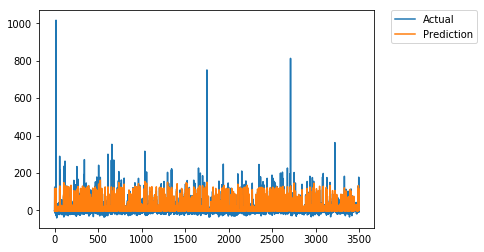

In [66]:
plt.plot(lr_prediction_sample_pd['id'] , lr_prediction_sample_pd['ArrDelay'],label='Actual')
#plt.plot(cv_prediction_sample_pd['id'] , cv_prediction_sample_pd['prediction'],label='CV_Prediction')
plt.plot(lr_prediction_sample_pd['id'] , lr_prediction_sample_pd['prediction'],label='Prediction')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.001)
plt.show()

In [67]:
training_df.count()

5482317

#### กรองบาง Tuples (Records) ทิ้งไปจาก testing set

In [68]:
from pyspark.ml.evaluation import RegressionEvaluator

#### นำโมเดลมาทำ Prediction ด้วยข้อมูล testing set ที่ไม่มีค่า Null และผ่านการกรองฯ แล้ว

In [69]:
everesult_df = dtModel.transform(test_df.dropna())

In [70]:
lr_evaluator_r2 = RegressionEvaluator\
(predictionCol="prediction",labelCol="ArrDelay",metricName="r2")
print("R Squared (R2) on test data = %g" \
      % lr_evaluator_r2.evaluate(everesult_df))

R Squared (R2) on test data = 0.706642


In [71]:
lr_evaluator_rmse = RegressionEvaluator\
(predictionCol="prediction",labelCol="ArrDelay",metricName="rmse")
print("Root Mean Squared Error (RMSE) on test data = %g" \
      % lr_evaluator_rmse.evaluate(everesult_df))

Root Mean Squared Error (RMSE) on test data = 20.96


In [72]:
end_time = t.time()

In [73]:
(end_time-start_time)/60

6.160718508561453

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [75]:
dtModel.stages[7].getInputCols()

['UniqueCarrierIndexed',
 'OriginVec',
 'DepTimeIndexed',
 'TaxiOut',
 'TaxiIn',
 'DepDelay',
 'DayOfWeek',
 'Distance']

In [76]:
depdelay_pd = training_df.select('DepDelay').toPandas()

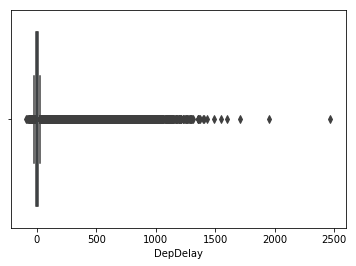

In [77]:
sns.boxplot(x=depdelay_pd["DepDelay"])

In [78]:
airline_row_df.withColumn('CRSElapsedTime',sparkf.col('CRSElapsedTime').cast(DoubleType()))\
.select('CRSElapsedTime').describe().show()

+-------+------------------+
|summary|    CRSElapsedTime|
+-------+------------------+
|  count|           6871696|
|   mean|129.15252930280968|
| stddev| 69.59357534499571|
|    min|            -141.0|
|    max|             660.0|
+-------+------------------+



In [79]:
CRSElapsedTime_pd = airline_row_df.withColumn('CRSElapsedTime',sparkf.col('CRSElapsedTime').cast(DoubleType()))\
.select('CRSElapsedTime').toPandas()

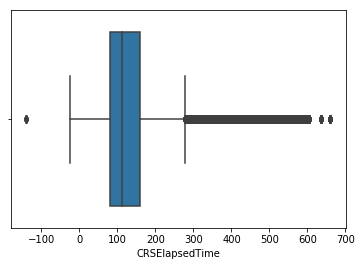

In [80]:
sns.boxplot(x=CRSElapsedTime_pd["CRSElapsedTime"])

In [81]:
airline_row_df.groupBy('Cancelled','CancellationCode','ArrDelay').count()\
.orderBy(sparkf.col('Cancelled').desc()).show(100)

+---------+----------------+--------+------+
|Cancelled|CancellationCode|ArrDelay| count|
+---------+----------------+--------+------+
|        0|            null|     -14|146983|
|        0|            null|     399|    35|
|        0|            null|     798|     2|
|        0|            null|      80|  5880|
|        0|            null|       8| 95471|
|        0|            null|      97|  3990|
|        0|            null|     149|  1655|
|        0|            null|     813|     3|
|        0|            null|      39| 17688|
|        0|            null|     185|   919|
|        0|            null|     357|    63|
|        0|            null|     480|    12|
|        0|            null|    1152|     1|
|        0|            null|     935|     1|
|        0|            null|      14| 62590|
|        0|            null|      51| 12018|
|        0|            null|      82|  5575|
|        0|            null|     378|    52|
|        0|            null|     325|    82|
|        0

In [82]:
final_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
UniqueCarrier,6855029,None,None,9E,YV
Origin,6855029,None,None,ABE,YUM
Dest,6855029,None,None,ABE,YUM
DepTime,6855029,None,None,00.01-05.59,18.00-24.00
TaxiOut,6855029,16.44368433744044,11.310620512037929,0.0,429.0
TaxiIn,6855029,6.860150263405158,4.931223682301742,0.0,308.0
DepDelay,6855029,9.923844961122702,35.20386329155055,-534.0,2467.0
DayOfWeek,6855029,3.92580191856227,1.9884594067642862,1.0,7.0
Distance,6855029,728.7438337605865,563.2447305232707,11.0,4962.0
